In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=Warning)

# 1. Normalizing Features with Graph Convolutional Networks

In [2]:
# Diagonal = Degree Matrix : How many connected?

np.random.seed(0)

D = np.array([[3, 0, 0, 0], 
              [0, 1, 0, 0], 
              [0, 0, 2, 0], 
              [0, 0, 0, 2]])
D

array([[3, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 2, 0],
       [0, 0, 0, 2]])

In [3]:
# Inverse Matrix
D_i = np.linalg.inv(D) # 1/3, 1/1, 1/2, 1/2
D_i

array([[0.33333333, 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        ],
       [0.        , 0.        , 0.5       , 0.        ],
       [0.        , 0.        , 0.        , 0.5       ]])

In [4]:
D@D_i # np.dot(D, D_i)

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [5]:
# Identity Matrix = self loop
np.identity(4) 

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [6]:
# renormalized degree matrix by adding self-loops
D + np.identity(4)

array([[4., 0., 0., 0.],
       [0., 2., 0., 0.],
       [0., 0., 3., 0.],
       [0., 0., 0., 3.]])

In [7]:
np.linalg.inv(D + np.identity(4)) # 1/4, 1/2, 1/3, 1/3

array([[0.25      , 0.        , 0.        , 0.        ],
       [0.        , 0.5       , 0.        , 0.        ],
       [0.        , 0.        , 0.33333333, 0.        ],
       [0.        , 0.        , 0.        , 0.33333333]])

Row Normalization: receiver centric
[[0.25       0.25       0.25       0.25      ]
 [0.5        0.5        0.         0.        ]
 [0.33333333 0.         0.33333333 0.33333333]
 [0.33333333 0.         0.33333333 0.33333333]]

Column Normalization: sender centric
[[0.25       0.5        0.33333333 0.33333333]
 [0.25       0.5        0.         0.        ]
 [0.25       0.         0.33333333 0.33333333]
 [0.25       0.         0.33333333 0.33333333]]



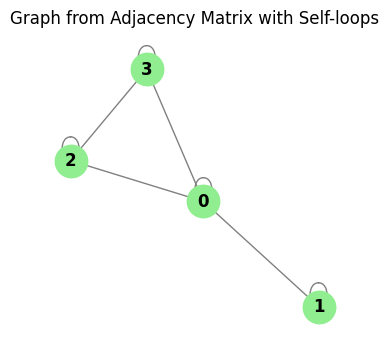

In [8]:
# Random Walk Normalization - one-direction
# Mean Aggregation
# A adjacent Matrix
A = np.array([[1, 1, 1, 1], 
              [1, 1, 0, 0], 
              [1, 0, 1, 1], 
              [1, 0, 1, 1]])
print("Row Normalization: receiver centric")
print(np.linalg.inv(D + np.identity(4)) @ A)
print("\nColumn Normalization: sender centric")
print(A @ np.linalg.inv(D + np.identity(4)))
print()

# Visualization
import networkx as nx

G = nx.from_numpy_array(A)

plt.figure(figsize=(3, 3))
nx.draw(G, 
        with_labels=True, 
        node_color='lightgreen', 
        node_size=500, 
        font_weight='bold', 
        edge_color='gray',
        linewidths=2)

plt.title("Graph from Adjacency Matrix with Self-loops")
plt.show()

In [9]:
# GCNConv Style Symmetric Normalization

A = np.array([[1, 1, 1, 1], 
              [1, 1, 0, 0], 
              [1, 0, 1, 1], 
              [1, 0, 1, 1]])

# Degree (sum of row)
degrees = np.sum(A, axis=1) # [4, 2, 3, 3]
D_inv_sqrt = np.diag(1.0 / np.sqrt(degrees))

# Symmetric Normalization 
A_symmetric = D_inv_sqrt @ A @ D_inv_sqrt ###

print("GCNConv Style Symmetric Normalization")
print(A_symmetric)

geometric_mean = (0.5 * 0.25) ** 0.5
geometric_mean

GCNConv Style Symmetric Normalization
[[0.25       0.35355339 0.28867513 0.28867513]
 [0.35355339 0.5        0.         0.        ]
 [0.28867513 0.         0.33333333 0.33333333]
 [0.28867513 0.         0.33333333 0.33333333]]


0.3535533905932738

# 2. Cora dataset loading

In [10]:
# 1. library
import torch

find_links = f"https://data.pyg.org/whl/torch-{torch.__version__}.html"

!pip install -q \
    torch-scatter \
    torch-sparse \
    torch-cluster \
    torch-spline-conv \
    torch-geometric \
    -f $find_links

# seed set
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)
    torch.cuda.manual_seed_all(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print("Installation Complete.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 75.8 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 95.3 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 51.1 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 1.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.5 MB/s eta 0:00:00a 0:00:01
Installation Complete.


In [11]:
# Cora dataset, papers as nodes and their citations as edges

import torch
import networkx as nx
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx

# Loading Cora dataset
# Graph Data Download by Planetoid
dataset = Planetoid(root="./cora_data", name="Cora")
data = dataset[0]

# daraset
print(f'Dataset: {dataset}')
print(f'Number of graphs (connected graph): {len(dataset)}')
print(f'Number of nodes (papers): {data.x.shape[0]}')
print(f'Number of features (vocabulary size): {dataset.num_features}')
print(f'Number of classes (research topics): {dataset.num_classes}')

print(f'\nGraph Info (connectivity):')
print(f'Edges are directed (one-way citation): {data.is_directed()}')
print(f'Graph has isolated nodes (papers): {data.has_isolated_nodes()}')
print(f'Graph has loops (self-citations): {data.has_self_loops()}')

# Node Features
df_x = pd.DataFrame(data.x.numpy())
df_x['label'] = pd.DataFrame(data.y)
print("\nData Preview:")
print(df_x)

Processing...


Dataset: Cora()
Number of graphs (connected graph): 1
Number of nodes (papers): 2708
Number of features (vocabulary size): 1433
Number of classes (research topics): 7

Graph Info (connectivity):
Edges are directed (one-way citation): False
Graph has isolated nodes (papers): False
Graph has loops (self-citations): False

Data Preview:
        0    1    2    3    4    5    6    7    8    9  ...  1424  1425  1426  \
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4     0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
2703  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   1.0   0.0   
2704  0.0  0.0  

Done!


In [12]:
df_x['label'].value_counts().sort_index()
# 0 'Theory'
# 1 'Reinforcement_Learning' 
# 2 'Genetic_Algorithms'    
# 3 'Neural_Networks'       
# 4 'Probabilistic_Methods' 
# 5 'Case_Based'           
# 6 'Rule_Learning'           

label
0    351
1    217
2    418
3    818
4    426
5    298
6    180
Name: count, dtype: int64

In [13]:
# Node Degree Distribution of the Cora Citation Network

from torch_geometric.datasets import Planetoid
from torch_geometric.utils import degree
from collections import Counter

# Get list of degrees for each node
degrees = degree(data.edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

df_degree = pd.DataFrame(list(numbers.items()), columns=['Degree', 'Number of Nodes'])
df_degree = df_degree.sort_values(by='Degree').reset_index(drop=True)

print(df_degree.head(10)) 

print(f"Max Degree: {df_degree['Degree'].max()}")
print(f"Min Degree: {df_degree['Degree'].min()}")

   Degree  Number of Nodes
0     1.0              485
1     2.0              583
2     3.0              553
3     4.0              389
4     5.0              281
5     6.0              131
6     7.0               82
7     8.0               57
8     9.0               25
9    10.0               26
Max Degree: 168.0
Min Degree: 1.0


Graph Count in dataset: 1


<BarContainer object of 37 artists>

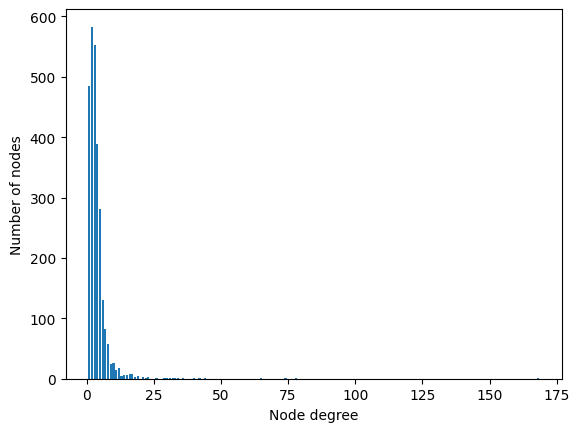

In [14]:
# Bar plot
print(f"Graph Count in dataset: {len(dataset)}") # a connected graph in the dataset

fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(), numbers.values())

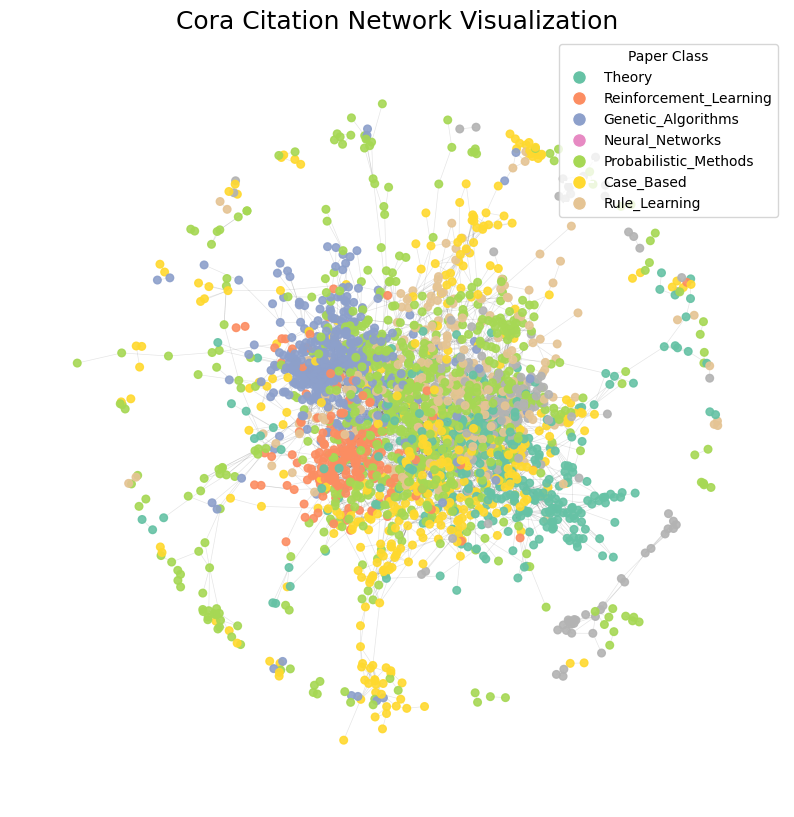

In [15]:
# Graph Visualization 

# Convert to NetworkX graph
G = to_networkx(data, to_undirected=True)

plt.figure(figsize=(10, 10))
plt.title("Cora Citation Network Visualization", fontsize=18)
plt.axis('off')  

# Calculating layout
position = nx.spring_layout(G, seed=42, k=0.15, iterations=50)

# node drawing
nx.draw_networkx_nodes(G, position, 
                       node_size=30, 
                       node_color=data.y, 
                       cmap=plt.cm.Set2,  
                       alpha=0.9)

# edge drawing
nx.draw_networkx_edges(G, position, alpha=0.1, width=0.5)

# Legend
labels_list = ['Theory',                  # 0
               'Reinforcement_Learning',  # 1
               'Genetic_Algorithms',      # 2
               'Neural_Networks',         # 3
               'Probabilistic_Methods',   # 4
               'Case_Based',              # 5
               'Rule_Learning'            # 6
              ]

colors = plt.cm.Set2(range(7))
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', 
                             label=label, markerfacecolor=color, markersize=10) 
                  for label, color in zip(labels_list, colors)]

plt.legend(handles=legend_handles, title="Paper Class", loc='upper right')

plt.show()

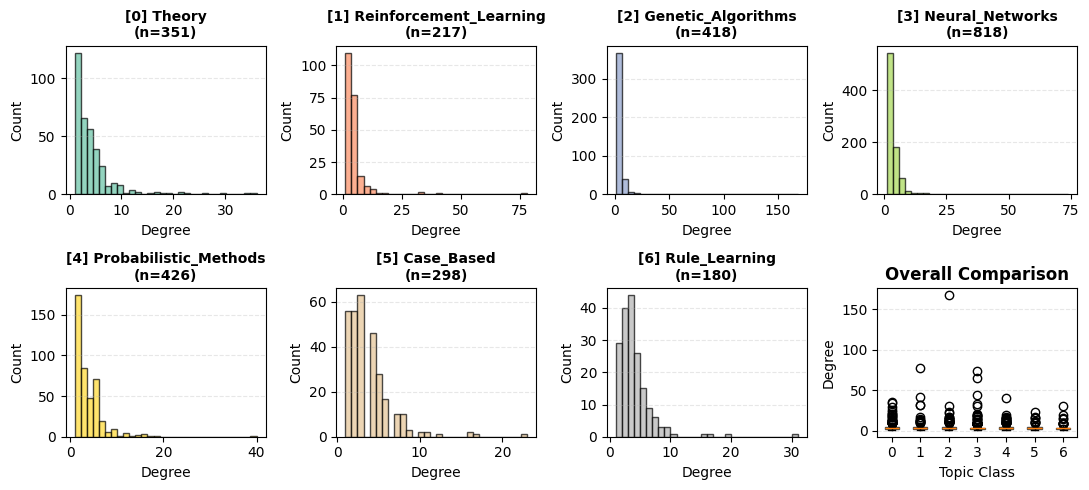

In [16]:
# node degree distributions in research topics

from torch_geometric.utils import degree

# 1. Degree Calculation & Data Preparation
degrees = degree(data.edge_index[0]).numpy()

topic_map = {
    0: 'Theory', 
    1: 'Reinforcement_Learning', 
    2: 'Genetic_Algorithms', 
    3: 'Neural_Networks', 
    4: 'Probabilistic_Methods', 
    5: 'Case_Based', 
    6: 'Rule_Learning'
}

df_analysis = pd.DataFrame({
    'Degree': degrees, 
    'Label': data.y.numpy()
})
df_analysis['Topic'] = df_analysis['Label'].map(topic_map)

# 2. Visualization
plt.figure(figsize=(11, 5)) 

colors = plt.cm.Set2(np.linspace(0, 1, 7))

for i in range(7):
    plt.subplot(2, 4, i + 1)
    
    subset = df_analysis[df_analysis['Label'] == i]['Degree']
    topic_name = topic_map[i]
    
    plt.hist(subset, bins=30, color=colors[i], edgecolor='black', alpha=0.7)
    plt.title(f"[{i}] {topic_name}\n(n={len(subset)})", fontsize=10, fontweight='bold')
    plt.xlabel('Degree')
    plt.ylabel('Count')
    plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.subplot(2, 4, 8)

data_to_plot = [df_analysis[df_analysis['Label'] == i]['Degree'] for i in range(7)]
bp = plt.boxplot(data_to_plot, patch_artist=True)

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.title("Overall Comparison", fontsize=12, fontweight='bold')
plt.xlabel("Topic Class")
plt.ylabel("Degree")
plt.xticks(range(1, 8), [i for i in range(7)]) 
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

In [17]:
# Summary Table
summary = df_analysis.groupby('Topic')['Degree'].agg(['count', 'mean', 'std', 'max']).sort_index()
print("\n[Topic-wise Degree Statistics Summary]")
print(summary)


[Topic-wise Degree Statistics Summary]
                        count      mean       std    max
Topic                                                   
Case_Based                298  3.644295  2.737872   23.0
Genetic_Algorithms        418  4.368421  8.655305  168.0
Neural_Networks           818  3.469438  4.543511   74.0
Probabilistic_Methods     426  3.737089  3.287965   40.0
Reinforcement_Learning    217  4.741935  6.761666   78.0
Rule_Learning             180  3.655555  3.280759   31.0
Theory                    351  4.350427  4.398668   36.0


# 3. GCN(Graph Convolutional Network)

In [18]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv

print(data)

# Data(x=[2708, 1433], 
# edge_index=[2, 10556], 
# y=[2708], 
# train_mask=[2708], val_mask=[2708], test_mask=[2708])

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [19]:
# 1. Model Definition 2 layers
conv1 = GCNConv(dataset.num_features, 16) # Layer-1: Input 1433 -> 16 Hidden
conv2 = GCNConv(16, dataset.num_classes) # Layer-2: 16 Hidden -> 7 Classes

# Optimizer Setup
optimizer = torch.optim.Adam(list(conv1.parameters()) + list(conv2.parameters()), 
                             lr=0.01, weight_decay=5e-4) # learning rate, L2 Regularization penalty

# accuracy function 
def get_accuracy(out, mask):
    pred = out.argmax(dim=1) # class with the highest probability
    correct = (pred[mask] == data.y[mask]).sum()
    return int(correct) / int(mask.sum())

# 2. Training Loop (Learning Phase)
conv1.train() 
conv2.train()

for epoch in range(101):
    # Forward Pass
    h = conv1(data.x, data.edge_index)
    h = torch.relu(h)
    out = conv2(h, data.edge_index)
    
    # Loss Calculation (Train Mask)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    
    # Backpropagation
    optimizer.zero_grad() # Reset gradients
    loss.backward()
    optimizer.step() # W update

    # Logging every 20 epochs
    if epoch % 20 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss:.4f}')

# 3. Final Check on Training Data 
conv1.eval() # Switch to evaluation mode
conv2.eval()

with torch.no_grad(): # No gradients needed for final evaluation
    # Forward pass with the trained weights
    h = conv1(data.x, data.edge_index)
    h = torch.relu(h)
    out = conv2(h, data.edge_index)
    
    # Calculate accuracy on Train Mask
    final_train_acc = get_accuracy(out, data.train_mask)
    print(f"Final Training Accuracy: {final_train_acc*100:.2f}%")

Epoch   0 | Loss: 1.9521
Epoch  20 | Loss: 0.1169
Epoch  40 | Loss: 0.0160
Epoch  60 | Loss: 0.0153
Epoch  80 | Loss: 0.0175
Epoch 100 | Loss: 0.0160
Final Training Accuracy: 100.00%


In [20]:
# Evaluation on Test Data 
with torch.no_grad():
    # Forward pass 
    h = conv1(data.x, data.edge_index)
    h = torch.relu(h)
    final_out = conv2(h, data.edge_index)
    
    # Calculate accuracy on Test Mask
    test_acc = get_accuracy(final_out, data.test_mask)
    print(f"Final Test Accuracy: {test_acc*100:.2f}%")

Final Test Accuracy: 80.90%


# 4. Predict Atom Hybridization (sp, sp2, sp3) using GCN

In [21]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.6/36.6 MB 45.0 MB/s eta 0:00:00:00:0100:01


In [22]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from rdkit import Chem
from rdkit.Chem import AllChem

# 1. Data Preparation Utils
# Define Hybridization Classes (Labels) 0: Other, 1: SP, 2: SP2, 3: SP3
HYBRID_MAP = {
    Chem.rdchem.HybridizationType.SP: 1,
    Chem.rdchem.HybridizationType.SP2: 2,
    Chem.rdchem.HybridizationType.SP3: 3
}

def one_hot_atom(atom):
    """
    Input: Atom object
    Output: One-hot vector [C, N, O, F, Other]
    Example: Carbon -> [1, 0, 0, 0, 0]
    """
    symbols = ['C', 'N', 'O', 'F']
    vec = [0] * (len(symbols) + 1)
    sym = atom.GetSymbol()
    
    if sym in symbols:
        vec[symbols.index(sym)] = 1
    else:
        vec[-1] = 1 # Other
    return vec

def smiles_to_data(smiles):
    # Converts SMILES -> PyG Data
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol) 

    # 1. Features(x) & Labels(y)
    features = []
    labels = []
    
    for atom in mol.GetAtoms():
        features.append(one_hot_atom(atom))
        hyb = atom.GetHybridization()
        labels.append(HYBRID_MAP.get(hyb, 0))

    x = torch.tensor(features, dtype=torch.float)
    y = torch.tensor(labels, dtype=torch.long)

    # 2. Edges (Adjacency)
    edge_indices = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_indices.append([i, j])
        edge_indices.append([j, i]) 

    if not edge_indices:
        edge_index = torch.empty((2, 0), dtype=torch.long)
    else:
        edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()

    return Data(x=x, y=y, edge_index=edge_index, smiles=smiles)

In [23]:
# 2. Data Verification (Interpret Data)

def interpret_vector(vec):
    """Convert one-hot vector back to element name for checking"""
    if vec[0] == 1: return "Carbon (C)"
    if vec[1] == 1: return "Nitrogen (N)"
    if vec[2] == 1: return "Oxygen (O)"
    if vec[3] == 1: return "Fluorine (F)"
    if vec[4] == 1: return "Other (H..)"
    return "Unknown"

def interpret_label(label_val):
    """Convert label index back to hybridization name"""
    mapping = {0: "Other", 1: "sp", 2: "sp2", 3: "sp3"}
    return f"{label_val} ({mapping.get(label_val, 'Unk')})"

print("\n=== [Step 1] Data Verification ===")
# Example molecules
check_list = ["CC", "C=C", "CC(=O)O"]

print(f"{'Atom':<5} | {'Feature Vector':<20} | {'Element':<15} | {'Label (Truth)':<15}")
print("="*65)

for smiles in check_list:
    print(f">>> Molecule: {smiles}")
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    
    for atom in mol.GetAtoms():
        atom_id = f"{atom.GetSymbol()}{atom.GetIdx()}"
        vector = one_hot_atom(atom)
        hyb = atom.GetHybridization()
        label = HYBRID_MAP.get(hyb, 0)
        
        print(f"{atom_id:<5} | {str(vector):<20} | {interpret_vector(vector):<15} | {interpret_label(label):<15}")


=== [Step 1] Data Verification ===
Atom  | Feature Vector       | Element         | Label (Truth)  
>>> Molecule: CC
C0    | [1, 0, 0, 0, 0]      | Carbon (C)      | 3 (sp3)        
C1    | [1, 0, 0, 0, 0]      | Carbon (C)      | 3 (sp3)        
H2    | [0, 0, 0, 0, 1]      | Other (H..)     | 0 (Other)      
H3    | [0, 0, 0, 0, 1]      | Other (H..)     | 0 (Other)      
H4    | [0, 0, 0, 0, 1]      | Other (H..)     | 0 (Other)      
H5    | [0, 0, 0, 0, 1]      | Other (H..)     | 0 (Other)      
H6    | [0, 0, 0, 0, 1]      | Other (H..)     | 0 (Other)      
H7    | [0, 0, 0, 0, 1]      | Other (H..)     | 0 (Other)      
>>> Molecule: C=C
C0    | [1, 0, 0, 0, 0]      | Carbon (C)      | 2 (sp2)        
C1    | [1, 0, 0, 0, 0]      | Carbon (C)      | 2 (sp2)        
H2    | [0, 0, 0, 0, 1]      | Other (H..)     | 0 (Other)      
H3    | [0, 0, 0, 0, 1]      | Other (H..)     | 0 (Other)      
H4    | [0, 0, 0, 0, 1]      | Other (H..)     | 0 (Other)      
H5    | [0, 0, 0, 0

In [24]:
# 3. Model Definition & Training

# Create Dataset
smiles_list = [
    "CC", "CCC", "C1CCCCC1",        # sp3
    "C=C", "CC=C", "C1=CC=CC=C1",   # sp2
    "C#C", "CC#C",                  # sp
    "CC(=O)O", "CNC", "C(=O)N"      # Mixed
]
dataset = [smiles_to_data(s) for s in smiles_list]
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# GCN Model
class HybridizationGCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.conv1 = GCNConv(num_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

model = HybridizationGCN(num_features=5, num_classes=4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.NLLLoss()

# Training Loop
model.train()
for epoch in range(101):
    total_loss = 0
    total_acc = 0
    num_samples = 0
    
    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pred = out.argmax(dim=1)
        total_acc += (pred == batch.y).sum().item()
        num_samples += batch.num_nodes

    if epoch % 20 == 0:
        print(f"Epoch {epoch:>3} | Loss: {total_loss/len(train_loader):.4f} | Acc: {total_acc/num_samples*100:.2f}%")

Epoch   0 | Loss: 1.3095 | Acc: 62.63%
Epoch  20 | Loss: 0.9525 | Acc: 66.67%
Epoch  40 | Loss: 0.8158 | Acc: 73.74%
Epoch  60 | Loss: 0.7096 | Acc: 74.75%
Epoch  80 | Loss: 0.6421 | Acc: 73.74%
Epoch 100 | Loss: 0.5970 | Acc: 80.81%


In [25]:
# 4. Test Molecule (Aspirin)

test_smiles = "CC(=O)OC1=CC=CC=C1C(=O)O" 
test_data = smiles_to_data(test_smiles)

model.eval()
with torch.no_grad():
    out = model(test_data.x, test_data.edge_index)
    pred = out.argmax(dim=1)

# Visualization of Results
mol = Chem.MolFromSmiles(test_smiles)
mol = Chem.AddHs(mol)
atoms = [a.GetSymbol() for a in mol.GetAtoms()]

# Map integer back to string
CLASS_TO_STR = {0: "Other", 1: "sp", 2: "sp2", 3: "sp3"}

print(f"Molecule: Aspirin ({test_smiles})")
print(f"{'Idx':<5} {'Atom':<5} {'True':<10} {'Predicted':<10} {'Correct?'}")
print("-" * 50)

for i, (p, y) in enumerate(zip(pred, test_data.y)):
    p_val = p.item()
    y_val = y.item()
    is_correct = "true" if p_val == y_val else "false"
    print(f"{i:<5} {atoms[i]:<5} {CLASS_TO_STR[y_val]:<10} {CLASS_TO_STR[p_val]:<10} {is_correct}")

Molecule: Aspirin (CC(=O)OC1=CC=CC=C1C(=O)O)
Idx   Atom  True       Predicted  Correct?
--------------------------------------------------
0     C     sp3        sp3        true
1     C     sp2        sp2        true
2     O     sp2        sp2        true
3     O     sp2        sp2        true
4     C     sp2        sp         false
5     C     sp2        sp2        true
6     C     sp2        sp2        true
7     C     sp2        sp2        true
8     C     sp2        sp         false
9     C     sp2        sp2        true
10    C     sp2        sp2        true
11    O     sp2        sp2        true
12    O     sp2        sp2        true
13    H     Other      Other      true
14    H     Other      Other      true
15    H     Other      Other      true
16    H     Other      Other      true
17    H     Other      Other      true
18    H     Other      Other      true
19    H     Other      Other      true
20    H     Other      Other      true


# 5. Predict Reaction Centers (Reactive Sites) in Molecules using GCN

In [26]:
# Task: Binary Node Classification (0: Inert, 1: Reactive)

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from rdkit import Chem

# 1. Data Preparation (Defining Ground Truth)

# Define Reactive Substructures (SMARTS patterns)
# In real research, these labels come from experimental reaction data.
# Here, we simulate them using common reactive functional groups.
REACTIVE_PATTERNS = {
    "Carbonyl Carbon (C=O)": "[CX3]=[OX1]",       # Electrophilic center
    "Amine Nitrogen (-NH)": "[NX3;H2,H1;!$(NC=O)]", # Nucleophilic center
    "Alcohol/Acid Oxygen (-OH)": "[OH1]",          # Nucleophilic center
    "Halogen (-X)": "[F,Cl,Br,I]",                 # Leaving group site
    "Double Bond Carbon (C=C)": "[CX3]=[CX3]"      # Addition reaction site
}

def get_reaction_labels(mol):
    """
    Label atoms as 1 (Reactive) if they match specific SMARTS patterns, else 0 (Inert).
    """
    labels = [0] * mol.GetNumAtoms() # Initialize all as Inert (0)
    
    for name, smarts in REACTIVE_PATTERNS.items():
        pattern = Chem.MolFromSmarts(smarts)
        if pattern:
            matches = mol.GetSubstructMatches(pattern)
            for match in matches:
                for idx in match:
                    labels[idx] = 1 # Mark as Reactive
    return labels

def one_hot_atom(atom):
    symbols = ['C', 'N', 'O', 'F', 'Cl', 'Br']
    vec = [0] * (len(symbols) + 1)
    sym = atom.GetSymbol()
    if sym in symbols:
        vec[symbols.index(sym)] = 1
    else:
        vec[-1] = 1 # Other
    return vec

def smiles_to_data(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol) 

    # 1. Features & Labels
    features = []
    # Generate Ground Truth Labels based on rules
    reaction_labels = get_reaction_labels(mol)
    
    for i, atom in enumerate(mol.GetAtoms()):
        features.append(one_hot_atom(atom))
        # Note: Hydrogen atoms are generally considered inert in this simplified model
        # unless explicitly handled, but we keep them in the graph for structure.
        
    x = torch.tensor(features, dtype=torch.float)
    y = torch.tensor(reaction_labels, dtype=torch.long)

    # 2. Edges
    edge_indices = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_indices.append([i, j])
        edge_indices.append([j, i])

    if not edge_indices:
        edge_index = torch.empty((2, 0), dtype=torch.long)
    else:
        edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()

    return Data(x=x, y=y, edge_index=edge_index, smiles=smiles)

# Dataset: Molecules with various reactive groups
smiles_dataset = [
    "CC(=O)C",       # Acetone (Carbonyl C is reactive)
    "CC(=O)O",       # Acetic acid (Carbonyl C, OH are reactive)
    "CCN",           # Ethylamine (N is reactive)
    "C=C",           # Ethene (C=C is reactive)
    "CCCl",          # Ethyl chloride (Cl and alpha-C are reactive sites)
    "c1ccccc1",      # Benzene (Relatively inert in this context)
    "CC(=O)N",       # Acetamide
    "CO",            # Methanol
]

dataset = [smiles_to_data(s) for s in smiles_dataset]
train_loader = DataLoader(dataset, batch_size=2, shuffle=True)

print(f"Dataset Created: {len(dataset)} molecules")
print(f"Reactive Center Definition: {list(REACTIVE_PATTERNS.keys())}")

Dataset Created: 8 molecules
Reactive Center Definition: ['Carbonyl Carbon (C=O)', 'Amine Nitrogen (-NH)', 'Alcohol/Acid Oxygen (-OH)', 'Halogen (-X)', 'Double Bond Carbon (C=C)']


In [27]:
# 2. Model Definition (Binary Classification GCN)

class ReactionGCN(torch.nn.Module):
    def __init__(self, num_features, num_classes=2):
        super().__init__()
        self.conv1 = GCNConv(num_features, 32)
        self.conv2 = GCNConv(32, 16)
        self.conv3 = GCNConv(16, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

# Input dimension: 7 (C, N, O, F, Cl, Br, Other)
model = ReactionGCN(num_features=7)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.NLLLoss() 

In [28]:
# 3. Training

model.train()

for epoch in range(101):
    total_loss = 0
    correct = 0
    total_atoms = 0
    
    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pred = out.argmax(dim=1)
        correct += (pred == batch.y).sum().item()
        total_atoms += batch.num_nodes

    if epoch % 20 == 0:
        print(f"Epoch {epoch:>3} | Loss: {total_loss:.4f} | Acc: {correct/total_atoms*100:.2f}%")

Epoch   0 | Loss: 2.7892 | Acc: 42.03%
Epoch  20 | Loss: 1.1407 | Acc: 92.75%
Epoch  40 | Loss: 1.1352 | Acc: 94.20%
Epoch  60 | Loss: 1.0781 | Acc: 94.20%
Epoch  80 | Loss: 1.0926 | Acc: 94.20%
Epoch 100 | Loss: 0.8260 | Acc: 94.20%


In [29]:
# 4. Predicting Reaction Centers for 'Aspirin'

# Aspirin: CC(=O)OC1=CC=CC=C1C(=O)O
# Expected Reactive Centers: Carbonyl Carbons, Ester Oxygen, Carboxyl OH
test_smiles = "CC(=O)OC1=CC=CC=C1C(=O)O"
test_data = smiles_to_data(test_smiles)

model.eval()
with torch.no_grad():
    out = model(test_data.x, test_data.edge_index)
    # Get probability of being Class 1 (Reactive)
    probs = torch.exp(out)[:, 1] 
    preds = out.argmax(dim=1)

# Visualization
mol = Chem.MolFromSmiles(test_smiles)
mol = Chem.AddHs(mol)
atoms = [a.GetSymbol() for a in mol.GetAtoms()]

print(f"{'Idx':<5} {'Atom':<5} {'Reactive? (Pred)':<20} {'Probability':<10}")
print("-" * 45)

for i, (pred, prob) in enumerate(zip(preds, probs)):
    is_reactive = "REACTIVE!" if pred == 1 else "Inert"
    # Highlight high probability atoms
    if pred == 1:
        print(f"{i:<5} {atoms[i]:<5} {is_reactive:<20} {prob:.4f}")
    else:
        pass

# "CC(=O)OC1=CC=CC=C1C(=O)O"

Idx   Atom  Reactive? (Pred)     Probability
---------------------------------------------
0     C     REACTIVE!            0.5460
1     C     REACTIVE!            1.0000
2     O     REACTIVE!            1.0000
3     O     REACTIVE!            1.0000
4     C     REACTIVE!            0.9997
9     C     REACTIVE!            0.9983
10    C     REACTIVE!            1.0000
11    O     REACTIVE!            1.0000
12    O     REACTIVE!            0.9699


# 6. Predict Partial Charges (Gasteiger Charge) of Atoms

In [30]:
# Node Regression (Predicting a continuous float value for each atom)

import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data

# 1. Data Preparation (Regression Labels)
def get_gasteiger_charges(mol):
    """
    Calculate Gasteiger Partial Charges using RDKit.
    Returns a list of float values (charges).
    """
    # Gasteiger charge calculation requires computing properties first
    AllChem.ComputeGasteigerCharges(mol)
    charges = []
    for atom in mol.GetAtoms():
        # Get computed charge. If not available, default to 0.0
        charge = float(atom.GetProp('_GasteigerCharge')) if atom.HasProp('_GasteigerCharge') else 0.0
        charges.append(charge)
    return charges

def one_hot_atom(atom):
    symbols = ['C', 'N', 'O', 'F', 'Cl', 'H'] # Include H for explicit graph
    vec = [0] * (len(symbols) + 1)
    sym = atom.GetSymbol()
    if sym in symbols:
        vec[symbols.index(sym)] = 1
    else:
        vec[-1] = 1 # Other
    return vec

def smiles_to_data(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol) # Partial charge distribution involves Hydrogens heavily

    # 1. Features & Labels
    features = []
    labels = get_gasteiger_charges(mol) # Float values!
    
    for atom in mol.GetAtoms():
        features.append(one_hot_atom(atom))
        
    x = torch.tensor(features, dtype=torch.float)
    # [Regression] Label shape: [Num_nodes, 1]
    y = torch.tensor(labels, dtype=torch.float).view(-1, 1)

    # 2. Edges
    edge_indices = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_indices.append([i, j])
        edge_indices.append([j, i])

    if not edge_indices:
        edge_index = torch.empty((2, 0), dtype=torch.long)
    else:
        edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()

    return Data(x=x, y=y, edge_index=edge_index, smiles=smiles)

# Dataset: Molecules with polarity
smiles_list = [
    "CC(=O)O", "CCO", "C1CCCCC1", "c1ccccc1", # Acetic acid, Ethanol, Cyclohexane, Benzene
    "CF", "CCl", "CN", "C[N+](=O)[O-]",       # Polar groups
    "C=O", "C(=O)N", "COC", "C#N", 
    "CCC(=O)N", "CNC(=O)C", "CC(C)O", "CC#N"
]

dataset = [smiles_to_data(s) for s in smiles_list]
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

print(f"Dataset Created: {len(dataset)} molecules")
print(f"Example Target (Charge): {dataset[0].y[0].item():.4f}")

Dataset Created: 16 molecules
Example Target (Charge): 0.0338


In [31]:
# 2. Model Definition (Regression GCN)

class ChargeGCN(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        # Input -> Hidden (32) -> Hidden (16) -> Output (1 scalar value)
        self.conv1 = GCNConv(num_features, 32)
        self.conv2 = GCNConv(32, 16)
        self.conv3 = GCNConv(16, 1) # Output dim is 1 (Regression)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.conv3(x, edge_index)
        # No activation (like Softmax) at the end for regression!
        return x

model = ChargeGCN(num_features=7) # C, N, O, F, Cl, H, Other
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss() # Mean Squared Error for Regression

In [32]:
# 3. Training

model.train()

for epoch in range(501): # More epochs for regression
    total_loss = 0
    
    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index)
        loss = criterion(out, batch.y) # MSE(Pred, Real)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    if epoch % 100 == 0:
        print(f"Epoch {epoch:>3} | MSE Loss: {total_loss/len(train_loader):.6f}")

Epoch   0 | MSE Loss: 0.030404
Epoch 100 | MSE Loss: 0.016646
Epoch 200 | MSE Loss: 0.010271
Epoch 300 | MSE Loss: 0.009948
Epoch 400 | MSE Loss: 0.008309
Epoch 500 | MSE Loss: 0.008608


Atom       True Charge     Pred Charge     Diff      
C0         0.0146          -0.1119         0.1265    
C1         0.2138          0.0645          0.1492    
O2         -0.2757         -0.1824         0.0933    
N3         -0.3699         -0.2412         0.1288    
H4         0.0330          0.1404          0.1074    
H5         0.0330          0.1404          0.1074    
H6         0.0330          0.1404          0.1074    
H7         0.1591          0.1514          0.0077    
H8         0.1591          0.1514          0.0077    


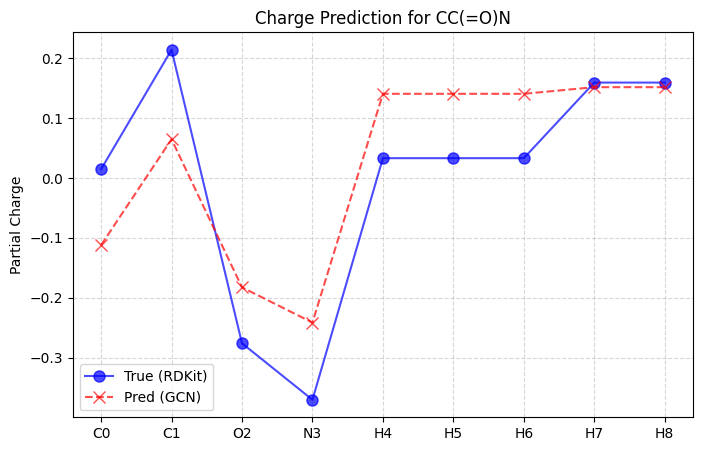

In [33]:
# 4. Predicting Partial Charges for 'Acetamide'

test_smiles = "CC(=O)N" 
test_data = smiles_to_data(test_smiles)

model.eval()
with torch.no_grad():
    pred = model(test_data.x, test_data.edge_index)

# Visualization
mol = Chem.MolFromSmiles(test_smiles)
mol = Chem.AddHs(mol)
atoms = [f"{a.GetSymbol()}{a.GetIdx()}" for a in mol.GetAtoms()]
y_true = test_data.y.flatten().numpy()
y_pred = pred.flatten().numpy()

# Comparison Table
print(f"{'Atom':<10} {'True Charge':<15} {'Pred Charge':<15} {'Diff':<10}")

for i in range(len(atoms)):
    diff = abs(y_true[i] - y_pred[i])
    print(f"{atoms[i]:<10} {y_true[i]:<15.4f} {y_pred[i]:<15.4f} {diff:<10.4f}")

# Plot
plt.figure(figsize=(8, 5))
plt.plot(y_true, 'bo-', label='True (RDKit)', markersize=8, alpha=0.7)
plt.plot(y_pred, 'rx--', label='Pred (GCN)', markersize=8, alpha=0.7)
plt.xticks(range(len(atoms)), atoms)
plt.ylabel("Partial Charge")
plt.title(f"Charge Prediction for {test_smiles}")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()